# 5. Chexnet Transformer Model EDA

### About this notebook

To check the input images that are fed into the Transformer model


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
CUDA = torch.cuda.is_available()
device = torch.device("cuda" if CUDA else "cpu")

### Load MNIST

At this point, do I really need to explain what this does?

In [3]:
import sys
# run the below line once only
if "..\\chexnet" not in sys.path:
    sys.path.insert(0,r'..\chexnet')
print(sys.path)

['..\\chexnet', 'c:\\Users\\siyang\\Documents\\GitHub\\DeepLearningProject\\notebooks', 'C:\\Python312\\python312.zip', 'C:\\Python312\\DLLs', 'C:\\Python312\\Lib', 'C:\\Python312', 'c:\\Users\\siyang\\Documents\\GitHub\\DeepLearningProject\\.venv', '', 'c:\\Users\\siyang\\Documents\\GitHub\\DeepLearningProject\\.venv\\Lib\\site-packages', 'C:\\Users\\siyang\\Documents\\GitHub\\DeepLearningProject', 'c:\\Users\\siyang\\Documents\\GitHub\\DeepLearningProject\\.venv\\Lib\\site-packages\\win32', 'c:\\Users\\siyang\\Documents\\GitHub\\DeepLearningProject\\.venv\\Lib\\site-packages\\win32\\lib', 'c:\\Users\\siyang\\Documents\\GitHub\\DeepLearningProject\\.venv\\Lib\\site-packages\\Pythonwin']


In [4]:
from DatasetGenerator import DatasetGenerator

In [6]:
pathDirData = '../raw_data/archive'
pathFileTrain = '../chexnet/dataset/train_1.txt'
pathFileVal = '../chexnet/dataset/val_1.txt'

transResize = 256
transCrop = 224
trBatchSize = 4
num_class = 14

normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

transformList = []
# transformList.append(transforms.Resize(transResize))
transformList.append(transforms.RandomResizedCrop(transCrop))
transformList.append(transforms.RandomHorizontalFlip())
transformList.append(transforms.ToTensor())
transformList.append(normalize)      
transformSequence=transforms.Compose(transformList)

datasetTrain = DatasetGenerator(pathImageDirectory=pathDirData, pathDatasetFile=pathFileTrain, transform=transformSequence)
datasetVal =   DatasetGenerator(pathImageDirectory=pathDirData, pathDatasetFile=pathFileVal, transform=transformSequence)
train_loader = DataLoader(dataset=datasetTrain, batch_size=trBatchSize, shuffle=True,  num_workers=12, pin_memory=True)
val_loader = DataLoader(dataset=datasetVal, batch_size=trBatchSize, shuffle=False, num_workers=12, pin_memory=True)

Collected 2048 images from ../chexnet/dataset/train_1.txt
Collected 2048 images from ../chexnet/dataset/val_1.txt


### See the image before it enters the model
After the transformations have been done

In [ ]:
# ## from line 708 to 749
# def show_images_from_dataloader(self, images):
#         import matplotlib.pyplot as plt
#         import numpy as np
#         # Assuming the dataloader returns (images, labels) tuples
#         # Assuming images are in (batch_size, channels, height, width) format
#         images = []
#         for i in range(len(images)):
#             image = images[i]
#             print('image tensor shape: ' + str(image.shape))
#             # print(filename[i])
#             # Convert tensor to numpy array
#             image_np = image.permute(1, 2, 0).numpy()  # Change tensor shape from (C, H, W) to (H, W, C)
#             images.append(image_np)
#             # plt.imshow(image_np)
#             # plt.axis('off')
#             # plt.show()
#         return images

#     def forward(self, x: Tensor) -> Tensor:

#         x = self.stem(x)
#         import matplotlib.pyplot as plt
#         import numpy as np
#         # Assuming the dataloader returns (images, labels) tuples
#         # Assuming images are in (batch_size, channels, height, width) format
#         images = []
#         for i in range(len(x)):
#             x_cpu = x.detach().cpu()
#             image = x_cpu[i,[0],:,:]
#             print('image tensor shape: ' + str(image.shape))
#             # print(filename[i])
#             # Convert tensor to numpy array
#             image_np = image.permute(1, 2, 0).numpy()  # Change tensor shape from (C, H, W) to (H, W, C)
#             images.append(image_np)
#             # plt.imshow(image_np)
#             # plt.axis('off')
#             # plt.show()
#         for block in self.blocks:
#             x = block(x)
#         x = self.classifier(x)
#         return x, images


In [7]:
import matplotlib.pyplot as plt
import numpy as np

def show_images_from_dataloader(images):
    # Assuming the dataloader returns (images, labels) tuples
        # Assuming images are in (batch_size, channels, height, width) format
        for i in range(len(images)):
            image = images[i]
            print('image tensor shape: ' + str(image.shape))
            # print(filename[i])
            # Convert tensor to numpy array
            image_np = image.permute(1, 2, 0).numpy()  # Change tensor shape from (C, H, W) to (H, W, C)
            # Display image
            plt.imshow(image_np)
            plt.axis('off')
            plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['../raw_data/archive\\images_012/images/00030286_004.png', '../raw_data/archive\\images_005/images/00009578_000.png', '../raw_data/archive\\images_012/images/00028804_000.png', '../raw_data/archive\\images_003/images/00005794_000.png']
image tensor shape: torch.Size([3, 224, 224])


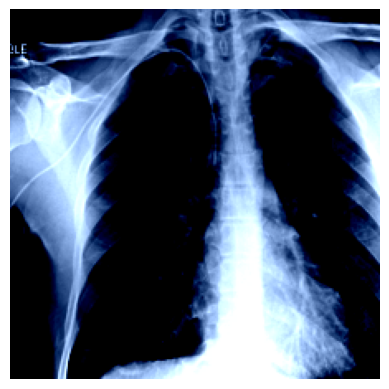

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image tensor shape: torch.Size([3, 224, 224])


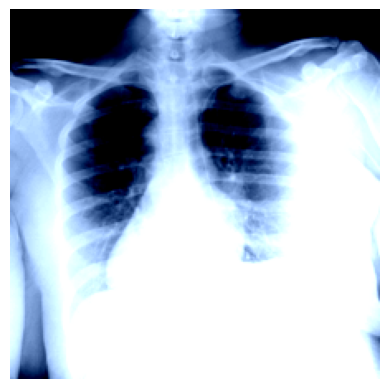

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image tensor shape: torch.Size([3, 224, 224])


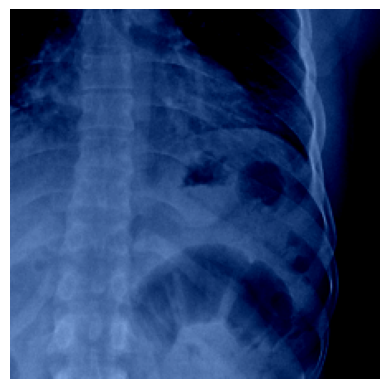

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image tensor shape: torch.Size([3, 224, 224])


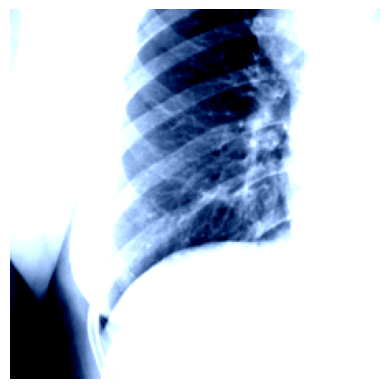

In [8]:
for images, _, filenames in train_loader:
    print(filenames)
    show_images_from_dataloader(images)
    break

### Define self-attention layer, and Transformer model

We will have to flatten the images to process them with Linear operations and attention operations.

In [9]:
# Define a self-attention layer implementation
class SelfAttentionLayer(nn.Module):
    def __init__(self, in_features):
        super(SelfAttentionLayer, self).__init__()
        self.in_features = in_features
        self.query = nn.Linear(in_features, in_features)
        self.key = nn.Linear(in_features, in_features)
        self.value = nn.Linear(in_features, in_features)

    def forward(self, x):
        batch_size = x.size(0)
        query = self.query(x).view(batch_size, -1, self.in_features)
        key = self.key(x).view(batch_size, -1, self.in_features)
        value = self.value(x).view(batch_size, -1, self.in_features)
        attention_weights = F.softmax(torch.bmm(query, key.transpose(1, 2))/(self.in_features**0.5), dim = 2)
        out = torch.bmm(attention_weights, value).view(batch_size, -1)
        return out

In [10]:
# Neural network definition using self-attention
class Transformer(nn.Module):
    def __init__(self):
        super(Transformer, self).__init__()
        # self.avg_pool = nn.AvgPool2d(8)
        self.dim_reduce = nn.Conv2d(in_channels = 3, out_channels=1, kernel_size = 1, stride = 1, padding = 0, bias = False)
        # self.fc1 = nn.Linear(28*28, 128)
        self.fc1 = nn.Linear(224*224, 128)
        self.attention1 = SelfAttentionLayer(128)
        self.fc2 = nn.Linear(128, 64)
        self.attention2 = SelfAttentionLayer(64)
        self.fc3 = nn.Linear(64, 14)

    def forward(self, x):
        # x = self.avg_pool(x)
        # print('output from self.avg_pool')
        # show_images_from_dataloader(x.cpu())
        x = self.dim_reduce(x)
        print('output from self.dim_reduce')
        show_images_from_dataloader(x.detach().cpu())
        # x = x.view(-1, 28*28)
        x = x.view(-1, 224 * 224)
        x = F.relu(self.fc1(x))
        x = self.attention1(x)
        x = F.relu(self.fc2(x))
        x = self.attention2(x)
        x = self.fc3(x)
        # x = nn.Softmax(x)

        return x

In [11]:
## function to calculate the F1 score
def f1_score(tp, fp, fn):
    return 2 * (tp) / (2 * tp + fp + fn)

['../raw_data/archive\\images_012/images/00030221_000.png', '../raw_data/archive\\images_007/images/00014647_007.png', '../raw_data/archive\\images_003/images/00006439_000.png', '../raw_data/archive\\images_003/images/00006492_001.png']
output from self.dim_reduce
image tensor shape: torch.Size([1, 224, 224])


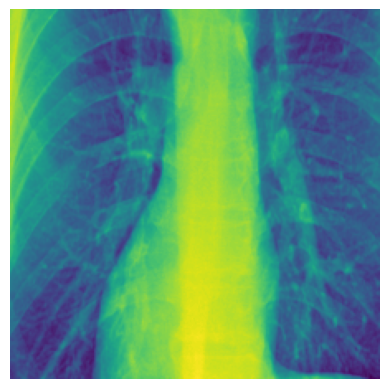

image tensor shape: torch.Size([1, 224, 224])


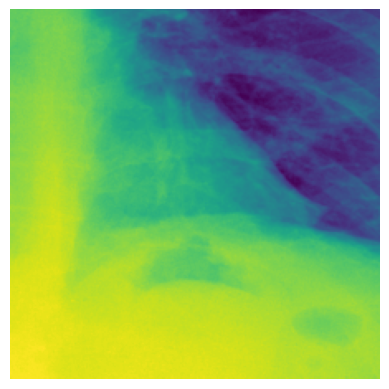

image tensor shape: torch.Size([1, 224, 224])


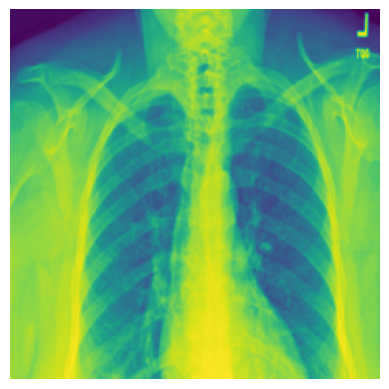

image tensor shape: torch.Size([1, 224, 224])


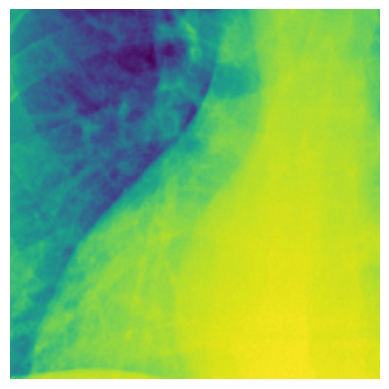

In [12]:
# Create model
model = Transformer().to(device)
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

# Train the model
n_epochs = 5
for epoch in range(n_epochs):
    tp_array = [0 for x in range(num_class)]
    fp_array = [0 for x in range(num_class)]
    fn_array = [0 for x in range(num_class)]
    for i, (images, labels, filenames) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        print(filenames)
        # Flatten image
        # print(images.shape)
        # images = images.reshape(-1, 28*28)

        # Forward pass
        outputs = model(images)
        # print("shape of input: "+ str(images.shape))
        # print("shape of output " + str(outputs.shape))
        # print("shape of labels: " + str(labels.shape))
        loss = criterion(outputs, labels)
        # calculate statistics
        pred_labels = (nn.Softmax(dim=1)(outputs) > 0.5).long()
        tp_array += sum(torch.logical_and(pred_labels, labels))
        fp_array += sum(torch.logical_and(torch.logical_xor(pred_labels, labels).long(), pred_labels))
        fn_array += sum(torch.logical_and(torch.logical_xor(pred_labels, labels).long(), labels))
        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Display
        break
    break